<a href="https://colab.research.google.com/github/danil99152/prediction-of-government-tenders/blob/main/forecasting_future_contract_stage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Changelog
*  Убрал полиномиальную и линейную регрессии из-за плохих результатов
*  Вынес подсчет ошибок в отдельный метод
*  Добавил проверку на значимость признаков через дерево решений (тоже склерн)
*  Случайный лес не оправдал ожиданий
*  Добавил XGBoost - результат как у нейронки и на 1% лучше, чем у логической регрессии
*  Проведен анализ по registration_period
*  registration_period выкинут из тренировочных и тестовых данных
*  Объединение в ансамбль
* Убрать форму поставщика
* Сплит по времени регистрации контракта
* CatBoost, xgboost c gridsearchcv - упор на них, отказаться от нейронки в последствии
* Добавили бейслайны
* Confusion matrix
* Добавил sklearn pipline with gridsearchcv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Импорт

In [ ]:
!pip install catboost

     |████████████████████████████████| 69.2MB 40kB/s 


In [ ]:
from datetime import datetime, date
import math
import re
import gc

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sbs
from statsmodels.graphics.mosaicplot import mosaic

from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import RMSprop
from keras.callbacks import Callback, TensorBoard, ModelCheckpoint
from keras.models import load_model

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb
import catboost as ctb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import joblib
import pickle

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Загрузка данных
!gdown --id 12QEoBsxSipCOdGObwPmU4n0EI96yHBWA

Downloading...
From: https://drive.google.com/uc?id=12QEoBsxSipCOdGObwPmU4n0EI96yHBWA
To: /content/contracts.csv
395MB [00:04, 84.3MB/s]


# Обработка данных

Считывание данных о контрактах

In [ ]:
contract_path = 'contracts.csv'
dtypes = {'product_code' : 'category', 
          'customer_legal_form' : 'category', 
          'supplier_legal_form' : 'category', 
          'current_contract_stage' : 'category'}
parse_dates = ['execution_period_start']
data = pd.read_csv(contract_path, dtype = dtypes, parse_dates = parse_dates, infer_datetime_format = True)
gc.collect()
data['execution_period_start'] = pd.to_datetime(data['execution_period_start'], format = "%Y-%m-%d", errors = 'coerce')
data.head()

,customer_legal_form,price,execution_period_start,product_code,supplier_legal_form,current_contract_stage,time
0,75403,356244.57,2020-01-01,35.14.10.000,12267,EC,366
1,75403,4186.65,2020-04-29,10.62.11.190,12300,ET,278
2,75404,1172120.74,2020-02-12,35.12.10.110,12300,EC,324
3,75404,2897696.00,2020-09-18,81.30.10.000,12300,EC,44
4,75203,5719.64,2020-01-01,36.00.20.130,65243,ET,366


Из системы госзакупок:
*   EC - Завершен
*   E - Выполяется
*   ET - Исполнение прекращено
*   IN - Контракт Аннулирован

Добавленные:
*   Unknown - Результат неизвестен

# Baselines

In [ ]:
EC = 1277451
ET = 245403

def baseline(major, minor):
  print("------------------")
  #Accuracy = (TP + TN) / (TP + TN + FP + FN)
  print("Accuracy:", (major + 0)/(major + 0 + minor + 0))
  #Precision = TP / (TP + FP)
  precision = major / (major + minor)
  print("Precision:", precision)
  #Recall = TP / (TP + FN)
  recall = major / (major + 0)
  print("Recall:", recall)
  #f1 = 2 * (precision * recall) / (precision + recall)
  print("f1:", 2 * (precision * recall) / (precision + recall))
  print("------------------")

def randomBaseline(major, minor):
  print("------------------")
  #Accuracy = (TP + TN) / (TP + TN + FP + FN)
  print("Accuracy:", (0.5*major + 0.5*minor)/(0.5*major + 0.5*minor + 0.5*minor + 0.5*major))
  #Precision = TP / (TP + FP)
  precision = 0.5*major / (0.5*major + 0.5*minor)
  print("Precision:", precision)
  #Recall = TP / (TP + FN)
  recall = 0.5*major / (0.5*major + 0.5*major)
  print("Recall:", recall)
  #f1 = 2 * (precision * recall) / (precision + recall)
  print("f1:", 2 * (precision * recall) / (precision + recall))
  print("------------------")

def skewedRandomBaseline(major, minor):
  perMajor = major / (major + minor)
  perMinor = minor / (minor + major)
  print("------------------")
  #Accuracy = (TP + TN) / (TP + TN + FP + FN)
  print("Accuracy:", (perMajor*major + perMinor*minor)/(perMajor*major + perMinor*minor + (1-perMinor)*minor + (1-perMajor)*major))
  #Precision = TP / (TP + FP)
  precision = perMajor*major / (perMajor*major + (1-perMinor)*minor)
  print("Precision:", precision)
  #Recall = TP / (TP + FN)
  recall = perMajor*major / (perMajor*major + (1-perMajor)*major)
  print("Recall:", recall)
  #f1 = 2 * (precision * recall) / (precision + recall)
  print("f1:", 2 * (precision * recall) / (precision + recall))
  print("------------------")

print("EC:")
baseline(EC, ET)
print("ET:")
baseline(ET, EC)
print("Random Baseline:")
print("EC:")
randomBaseline(EC, ET)
print("ET:")
randomBaseline(ET, EC)
print("Skewed Random Baseline:")
print("EC:")
skewedRandomBaseline(EC, ET)
print("ET:")
skewedRandomBaseline(ET, EC)

EC:
------------------
Accuracy: 0.8388532321548882
Precision: 0.8388532321548882
Recall: 1.0
f1: 0.9123656173166852
------------------
ET:
------------------
Accuracy: 0.16114676784511187
Precision: 0.16114676784511187
Recall: 1.0
f1: 0.27756485623978866
------------------
Random Baseline:
EC:
------------------
Accuracy: 0.5
Precision: 0.8388532321548882
Recall: 0.5
f1: 0.6265460709272453
------------------
ET:
------------------
Accuracy: 0.5
Precision: 0.16114676784511187
Recall: 0.5
f1: 0.24373826763207293
------------------
Skewed Random Baseline:
EC:
------------------
Accuracy: 0.729643025883629
Precision: 0.838853232154888
Recall: 0.838853232154888
f1: 0.838853232154888
------------------
ET:
------------------
Accuracy: 0.729643025883629
Precision: 0.1611467678451119
Recall: 0.16114676784511187
f1: 0.16114676784511187
------------------


# Тестируем бустинги

In [ ]:
print("EC", len(data[data['current_contract_stage']=='EC']))
print("ET", len(data[data['current_contract_stage']=='ET']))

EC 6163559
ET 1450711


In [ ]:
data.sort_values('execution_period_start', inplace = True)
x = data.copy()
y = data.drop(['customer_legal_form',	'price',	'product_code',	'supplier_legal_form', 'time'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle = False)

In [ ]:
#Балансировка тренировочных данных
old_indexes = round(len(x_train[x_train['current_contract_stage']=='EC'])
 - len(x_train[x_train['current_contract_stage']=='ET']))
x_train.sort_values('current_contract_stage', inplace = True)
x_train = x_train.reset_index(drop=True)
x_train.drop(x_train[((x_train.index < old_indexes) & (x_train['current_contract_stage']=="EC"))].index, inplace=True)

y_train.sort_values('current_contract_stage', inplace = True)
y_train = y_train.reset_index(drop=True)
y_train.drop(y_train[((y_train.index < old_indexes) & (y_train['current_contract_stage']=="EC"))].index, inplace=True)
gc.collect()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


129

In [ ]:
print("EC", len(x_train[x_train['current_contract_stage']=='EC']))
print("ET", len(x_train[x_train['current_contract_stage']=='ET']))

EC 1205308
ET 1205308


In [ ]:
print("EC", len(x_test[x_test['current_contract_stage']=='EC']))
print("ET", len(x_test[x_test['current_contract_stage']=='ET']))

EC 1277451
ET 245403


In [ ]:
x_train_EC = x_train[x_train['current_contract_stage']=='EC']
x_train_ET = x_train[x_train['current_contract_stage']=='ET']
y_train_EC = y_train[y_train['current_contract_stage']=='EC']
y_train_ET = y_train[y_train['current_contract_stage']=='ET']

percent = 0.75 #% разницы между тренировочными EC и ET
droped = round(len(y_train_ET)*percent)
x_train_EC.drop(x_train_EC[x_train_EC.index < droped].index, inplace=True)
x_train_EC = x_train_EC.reset_index(drop=True)
y_train_EC.drop(y_train_EC[y_train_EC.index < droped].index, inplace=True)
y_train_EC = y_train_EC.reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
x_train = pd.concat([x_train_EC, x_train_ET])
y_train = pd.concat([y_train_EC, y_train_ET])

x_train.sort_values('execution_period_start', inplace = True)
y_train.sort_values('execution_period_start', inplace = True)

In [ ]:
print('EC', len(y_test[y_test['current_contract_stage'] == 'EC'].index))
print('ET', len(y_test[y_test['current_contract_stage'] == 'ET'].index))

EC 1277451
ET 245403


In [ ]:
print('EC', len(y_train[y_train['current_contract_stage'] == 'EC'].index))
print('ET', len(y_train[y_train['current_contract_stage'] == 'ET'].index))

EC 301327
ET 1205308


In [ ]:
print("Разница в трен данных:", 1 - len(y_train[y_train['current_contract_stage'] == 'EC'].index)/len(y_train[y_train['current_contract_stage'] == 'ET'].index))

Разница в трен данных: 0.750000414832416


In [ ]:
x_train = x_train.drop(['current_contract_stage', 'execution_period_start'], axis=1)
y_train = y_train.drop(['execution_period_start'], axis=1)
x_test = x_test.drop(['current_contract_stage', 'execution_period_start'], axis=1)
y_test = y_test.drop(['execution_period_start'], axis=1)

In [ ]:
del x_train_EC, x_train_ET, y_train_EC, y_train_ET, x, y
gc.collect()

44

CatBoost (для поставщиков)

In [ ]:
x_train = x_train.drop(['time'], axis=1)
x_test = x_test.drop(['time'], axis=1)

In [ ]:
x_train = x_train.drop(['price'], axis=1)
x_test = x_test.drop(['price'], axis=1)

              precision    recall  f1-score   support

          EC       0.96      0.41      0.57   1277449
          ET       0.23      0.91      0.36    245405

    accuracy                           0.49   1522854
   macro avg       0.59      0.66      0.47   1522854
weighted avg       0.84      0.49      0.54   1522854



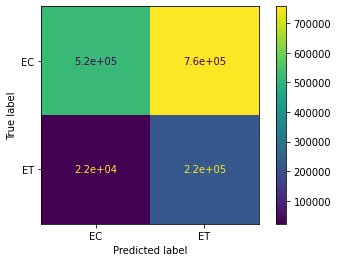

In [ ]:
# 75% - оптимиальная разница между классами

cat_features = ['customer_legal_form', 'product_code', 'supplier_legal_form']
model_catboost = CatBoostClassifier(
    n_estimators = 300,
    learning_rate = 0.01,
    max_depth = 5,
    task_type="GPU",
    devices='0:1',
).fit(x_train, y_train, cat_features,
      eval_set=(x_test, y_test),
             use_best_model=True,
             verbose=False)
y_pred = model_catboost.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['EC', 'ET']))

cm = confusion_matrix(y_test, y_pred, labels=model_catboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_catboost.classes_)
disp.plot()

Best parameters {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}
Mean cross-validated accuracy score of the best_estimator: 0.843
              precision    recall  f1-score   support

          EC       0.96      0.41      0.58   1277449
          ET       0.23      0.91      0.37    245405

    accuracy                           0.49   1522854
   macro avg       0.59      0.66      0.47   1522854
weighted avg       0.84      0.49      0.54   1522854



363

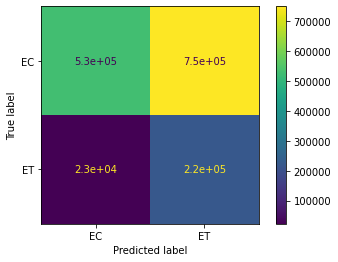

In [ ]:
cat_features = ['customer_legal_form', 'product_code', 'supplier_legal_form']
 
parameters = {
    "n_estimators": [300,250],
    "learning_rate": [0.01],
    "max_depth": [5,4],
}
 
model_catboost = CatBoostClassifier(
    cat_features = cat_features,
    random_state=42,
    task_type="GPU",
    devices='0:1',
)
 
model_catboost = GridSearchCV(
    model_catboost, 
    parameters, 
    cv=5,
    scoring='accuracy',
)
 
model_catboost.fit(x_train, y_train, eval_set=(x_test, y_test),
             use_best_model=True,
             verbose=False)
 
print(f'Best parameters {model_catboost.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_catboost.best_score_:.3f}'
)
 
y_pred = model_catboost.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['EC', 'ET']))
 
cm = confusion_matrix(y_test, y_pred, labels=model_catboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_catboost.classes_)
disp.plot()
 
del y_pred
gc.collect()

In [ ]:
#значимость признаков для леса
importances = model_catboost.best_estimator_.get_feature_importance()
indices = np.argsort(importances)[::-1]
col = ['customer_legal_form',	'product_code',	'supplier_legal_form']
ar_f=[]
for f, idx in enumerate(indices):
    ar_f.append([round(importances[idx],4), col[idx]])
print("Значимость признака:")
ar_f.sort(reverse=True)
ar_f

Значимость признака:


[[50.057, 'product_code'],
 [26.0021, 'supplier_legal_form'],
 [23.9409, 'customer_legal_form']]

In [ ]:
model_catboost.best_estimator_.save_model("/content/drive/MyDrive/Модели-предсказатели завершенности тендеров/final/catboost_for_supp")

CatBoost (для заказчиков)

In [ ]:
x_train = x_train.drop(['supplier_legal_form'], axis=1)
x_test = x_test.drop(['supplier_legal_form'], axis=1)

              precision    recall  f1-score   support

          EC       0.96      0.41      0.57   1277449
          ET       0.23      0.92      0.37    245405

    accuracy                           0.49   1522854
   macro avg       0.60      0.66      0.47   1522854
weighted avg       0.84      0.49      0.54   1522854



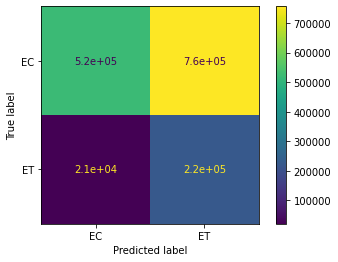

In [ ]:
cat_features = ['customer_legal_form', 'product_code']
model_catboost = CatBoostClassifier(
    n_estimators = 200,
    learning_rate = 0.01,
    max_depth = 4,
    task_type="GPU",
    devices='0:1',
).fit(x_train, y_train, cat_features,
      eval_set=(x_test, y_test),
             use_best_model=True,
             verbose=False)
y_pred = model_catboost.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['EC', 'ET']))

cm = confusion_matrix(y_test, y_pred, labels=model_catboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_catboost.classes_)
disp.plot()

Best parameters {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}
Mean cross-validated accuracy score of the best_estimator: 0.842
              precision    recall  f1-score   support

          EC       0.96      0.41      0.57   1277449
          ET       0.23      0.91      0.37    245405

    accuracy                           0.49   1522854
   macro avg       0.60      0.66      0.47   1522854
weighted avg       0.84      0.49      0.54   1522854



3851

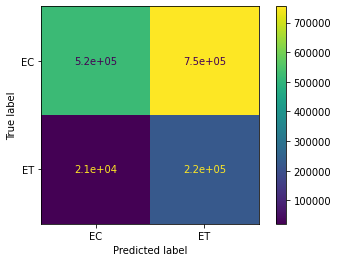

In [83]:
cat_features = ['customer_legal_form', 'product_code']
 
parameters = {
    "n_estimators": [200,250],
    "learning_rate": [0.01],
    "max_depth": [4,5],
}
 
model_catboost = CatBoostClassifier(
    cat_features = cat_features,
    random_state=42,
    task_type="GPU",
    devices='0:1',
)
 
model_catboost = GridSearchCV(
    model_catboost, 
    parameters, 
    cv=5,
    scoring='accuracy',
)
 
model_catboost.fit(x_train, y_train, eval_set=(x_test, y_test),
             use_best_model=True,
             verbose=False)
 
print(f'Best parameters {model_catboost.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_catboost.best_score_:.3f}'
)
 
y_pred = model_catboost.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['EC', 'ET']))
 
cm = confusion_matrix(y_test, y_pred, labels=model_catboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_catboost.classes_)
disp.plot()
 
del y_pred
gc.collect()

In [85]:
#значимость признаков для леса
importances = model_catboost.best_estimator_.get_feature_importance()
indices = np.argsort(importances)[::-1]
col = ['customer_legal_form',	'product_code']
ar_f=[]
for f, idx in enumerate(indices):
    ar_f.append([round(importances[idx],4), col[idx]])
print("Значимость признака:")
ar_f.sort(reverse=True)
ar_f

Значимость признака:


[[58.9932, 'product_code'], [41.0068, 'customer_legal_form']]

In [ ]:
model_catboost.save_model("/content/drive/MyDrive/Модели-предсказатели завершенности тендеров/final/catboost_for_cust")